In [2]:
#Para machacar datos
import numpy as np
import pandas as pd
#Astrofisica
import astropy.units as u
from astropy.time import Time
from poliastro.bodies import Earth, Sun
from poliastro.twobody import State
from poliastro.maneuver import Maneuver
from poliastro.iod import izzo
from poliastro.plotting import plot, OrbitPlotter
from poliastro import ephem
from poliastro.util import norm
ephem.download_kernel("de421")

#Kung fu
from shaolin.core.dashboard import Dashboard
from shaolin.dashboards.slicers import ArraySlicer, AxisPlot, DataFrameSlicer, PanelSlicer
from shaolin.dashboards.plot_mappers import PlotMapper
from shaolin.dashboards.colormap import ColormapPicker
#Plotting with Vpython and Plotly
import vpython as vp
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.core.display import clear_output


File de421.bsp already exists under /home/kalidus/.poliastro


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
init_notebook_mode(connected=True)

In [4]:
%%HTML
<style>
.widget-area{ width:100% !important;}
.output-area{ width:150% !important;}
</style>

 # Per Shaolin ad Astra

  * ### **Per Python ad Astra.**
  * ### **Interactive data kung fu with Shaolin.**
  
  <br><div class="title slide" style="text-align:center;font-size:120%;">Guillem Duran Ballester(@miau_db)   &<br>   Juan Luis Cano(@astrojuanlu) </div>

 This talk is a combination of two talks presented at EuroPython 2016.
 - <a href="https://www.youtube.com/watch?v=VCpTgU1pb5k">Per python ad astra</a>, presented by Juan Luis Cano is a talk about the Juno mission that landed on july 2016 in Jupyter, where he calculates the trajectory followed by Juno using Poliastro.
 
- <a href="https://www.youtube.com/watch?v=hnp-bvizDOA">Interactive data kung fu with Shaolin</a>, Presented by Guillem Duran, is a presentation of the *shaolin* python package intended for building complex data visualizations. 

# Juno's odisey
1. ### ¿What is the Juno mission?
2.  ### Cosmic billiards.
3. ### Playing cosmic billiards.

In this talk we will show how it is possible to replicate the trajectory followed by Juno from the Earth to Jupiter.
This talk will be divided in three different topics. <br>
First we will talk about the Juno misison and its goals and motivations. <Br>
Later we will show how it is possible to replicate any spatial trajectory using poliastro, and the basic principles behind orbital mechanics. <Br>
Finally we will show how this trajectory can be animated using Vpython.

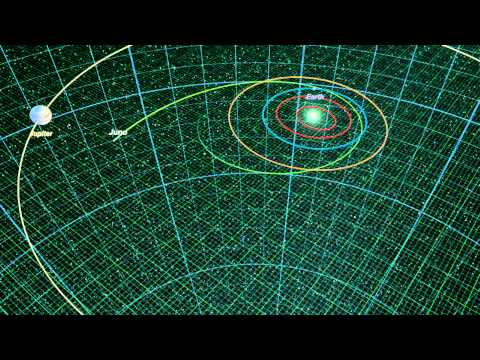

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo("sYp5p2oL51g")

# Dates worth considering
1. ## Launch from Earth--> 2011-08-05
2. ## Deep space manouver --> 2012-09-01
3. ## Earth Flyby --> 2013-10-09
4. ## Arrival to Jupiter --> 2016-07-05

The Juno mission has 4 important dates:

- Launch date: This is when Juno was launched into space. Once launched, Juno won't use any fuel until it performs the deep space manouver(DSM).

- DSM: In this date, Juno will change its trajectory. The new trajectory will be the one that allows it to perform a flyby at the Earth on 09-10-2013.

- Flyby: A <a href="https://en.wikipedia.org/wiki/Planetary_flyby">flyby</a> is a space manouver that Juno will perform to increase its velocity by taking advantage of the Earth gravity, so it can reach to Jupiter

## Dates for pandas indexing pourposes

In [9]:
launch_dt = "2011-08-05"
aph_dt = '2012-09-01'
flyby_dt = "2013-10-09"
arrival_dt = "2016-07-05"

## Dates for poliastro calculations

In [10]:
date_flyby = Time("2013-10-09 19:21", scale='utc')
date_arrival = Time("2016-07-05 03:18", scale='utc')
launch_date = Time("2011-08-05 16:25", scale='utc')

# Cosmic Billiards 101

## The table

- ### The table is like a trampolin with a wrecking ball at the center.
- ### Three dimentional.

This means that we are suposing that each particle(ball) in our system is only subjected to the gravitational influence of only one object(wrecking ball/Sun) at a time. We also assume there is no loss of energy due to friction and all the forces involved in our calculations are conservative. 

<img src="images/trampolin.jpeg">

## The balls --> State:
- ### The balls do not interact with each other.

- ### Defined by a table and (x,v,t).

- ### No direct hits allowed.

- ### You can Move them. 

# Moving the balls

- ## The Euler.
- ## The Lambert.
- ## Impulse.

In poliastro the *state* is the object that contains all the information needed to perform calculations. Each state represents a point in the space phase defined by our motion equations and it has **v**, **x**, and *t* coordinates. The *state* object also holds information related to the orbit that it would follow if propagated like the energy or the period. 

It is also possible to use a *state* to solve either the Kepler problem and the Lambert problem. It is also possible to perform impulse manouvers on a given state in order to change its velocity externally. 

In order to create a new *state* only a center of reference(table), position and velocity vectors, and a time coordinate.

# The Euler:

- Starting from **x0**,**v0**,*t0* you ask **x1**,**v1** at time *t1*.
- The ball cannot be hit from *t0* to *t1*.
- The ball will follow a line named orbit periodically.
- Also called "**propagation**".

Poliastro allows us to solve the Kepler problem. This means that once we have a ball set on our table, we will just let that ball move undisturbed along our billiards table. This means that as our ball will follow an orbit, we will be able to automatically calculate in which point of the orbit our ball will be at a given time. 

# The Lambert

* You know **r0**, **r1** and the time of flight (*t1*-*t0*).
* You get **v0**, **v1**.
* Now you can build the full initial and final states.

The Lambert "move" allow us to find how we have to hit a ball in order to get it to a given new position after the given time of flight. This means that we are told the velocity that would be needed to get a new state that starting from **r0** could be propagated to **r1** after the given time.  

# Impulse
- Direct hit to the ball.
- Changes its orbit (ads a vctor to its current velocity).
- Same as deleting the ball and creating a new one with same **x**,*t* but new **v**.

The impulse manouver allow us to change the velocity vector of a given state. This change in the velocity vector will change the current orbit of the state. 

In [29]:
orbit_plot = Scatter3D(full_orbits)
orbit_plot.widget

Here it is possible to see three different orbits. Each point in this orbits would correspond to a state at a different time. Note the periodicity of the propagated states. Now that we know the cosmc billiards rules we can try to replicate Juno's trajectory. 

If we propagate the earth and Jupiter initial states, as they are left free (You cannot hit a plannet in real life) we can see its orbits during the duration os Juno's mission. 

In order to plot the Juno's trajectory a few tricks will be required.

# Calculating Juno's journey

## 5 states are required: 2 Planets , 3 Juno

### Jupiter and Earth initial states

In [46]:
# Initial state of the Earth
r_e0, v_e0 = ephem.planet_ephem(ephem.EARTH, launch_date)
ss_e0 = State.from_vectors(Sun, r_e0, v_e0, epoch=launch_date)

#Jupiter at launch date
r_j, v_j = ephem.planet_ephem(ephem.JUPITER, launch_date)
ss_j = State.from_vectors(Sun, r_j, v_j, epoch=launch_date)

## Juno needs 3 states

- Launch.
- Deep space manouver.
- Flyby.

As we can only propagate orbits withs no perturbations we will need three different states in order to account for the three manouvers performed by Juno. We will model the trajectory followed after each manouver as a new orbit.

# Juno Launch

In [33]:
#Direction of earth velocity
C_3 = 31.1 * u.km**2 / u.s**2
dv = C_3**.5 * v_e0 / norm(v_e0)

In [35]:
#Launch maneuver
man = Maneuver.impulse(dv)
launch_state = ss_e0.apply_maneuver(man)

# Inner cruise until deep space manouver

In [37]:
# Inner Cruise from Earth
ss_aph = launch_state.propagate(launch_state.period / 2)

Here we are using a "Kepler Move" in order to find the state of Juno when performing the deep space manouver


# State after deep space manouver

In [47]:
# State of the Earth the day of the flyby
r_earth_fly, v_earth_fly = ephem.planet_ephem(ephem.EARTH, date_flyby)

#Velocities before and after the back to Earth trajectory
time_of_flight = date_flyby - ss_aph.epoch
(v_aph, v_fly), = izzo.lambert(Sun.k, ss_aph.r, r_earth_fly, time_of_flight)
#Juno state after manouver
ss_aph_post = State.from_vectors(Sun, ss_aph.r, v_aph)

Here we are solving Lmabert's problem to find what the velocity will be after the deep space manouver if we waant to get to the Earth the day of the flyby.

# Flyby manouver

In [42]:
#Jupiter at arrival
r_j, v_j = ephem.planet_ephem(ephem.JUPITER, date_arrival)
time_to_jupiter = date_arrival - date_flyby
(v_flypre, v_arrival), = izzo.lambert(Sun.k, r_earth_fly, r_j, time_to_jupiter)

#State after the flyby
ss_oip = State.from_vectors(Sun, r_earth_fly, v_flypre, epoch=date_flyby)

Now we have calculated the 5 states needed to get the Juno's trajectory. Now we only have to propagate each state for the required time using the state propagator.

# Describing the orbits

In [48]:
state_dict = {'Earth':[ss_e0,launch_dt,arrival_dt],
              'Inner Cruise':[launch_state,launch_dt,aph_dt],
              "Back to Earth":[ss_aph_post,aph_dt,flyby_dt],
              "Jupiter Orbit Insertion Phase":[ss_oip,flyby_dt,arrival_dt],
              "Jupiter":[ss_j,launch_dt,arrival_dt]              
             }

full_orbits_dict = {'Earth':[ss_e0],
                    'Inner Cruise':[launch_state],
                    "Back to Earth":[ss_aph_post],
                    "Jupiter Orbit Insertion Phase":[ss_oip],
                    "Jupiter":[ss_j]              
                   }  

In order to simulataneously calculate state propagations during a period of time(drawing a "piece" of orbit) we can use the StatePropagator and feed a dictionary containing the following information:

- Name of the trajectory as key.
- List containing: [initial_state, start_date, end_date].

# Propagating the orbits

In [49]:
state_propagator  = StatePropaGator(state_dict,
                                    date_launch=launch_dt,
                                    date_arrival=arrival_dt)
state_propagator.widget

ready


In [ ]:
_data_df = state_propagator.data.copy().dropna(axis=1,how='all')
_data_df.to_pickle('propagated_juno.pck')
data_df = _data_df

In [23]:
data_df = pd.read_pickle('propagated_juno.pck')

In [24]:
orbit_plot.data = data_df

# Calculating the full orbits

This will get the data of the 5 orbits during all the mission's duration. 

In [27]:
state_propagator.state_dict = full_orbits_dict
state_propagator.update()
_full_orbits = state_propagator.data.copy()
_full_orbits.dropna(axis=1,how='all').to_pickle('full_orbits.pck')

state      Back to Earth                                                  \
value              mod_r    mod_v           rx           ry           rz   
2011-08-05   3.47033e+08  14.1767 -2.42876e+08  2.27427e+08  9.85915e+07   
2011-08-06   3.47025e+08  14.1773 -2.43743e+08  2.26634e+08  9.82476e+07   
2011-08-07   3.47013e+08  14.1783 -2.44605e+08  2.25835e+08  9.79015e+07   
2011-08-08   3.46997e+08  14.1796 -2.45461e+08  2.25031e+08   9.7553e+07   
2011-08-09   3.46977e+08  14.1811 -2.46311e+08  2.24222e+08  9.72022e+07   

state                                                    Earth   ...     \
value             time       vx       vy       vz        mod_r   ...      
2011-08-05  2011/08/05 -10.0744  -9.1518 -3.96597  1.51441e+08   ...      
2011-08-06  2011/08/06 -10.0077 -9.21409 -3.99297  1.51412e+08   ...      
2011-08-07  2011/08/07 -9.94069 -9.27617 -4.01988  1.51382e+08   ...      
2011-08-08  2011/08/08 -9.87345 -9.33803  -4.0467  1.51352e+08   ...      
2011-08-09  2011/08/09 -9.80596 -9.39969 -4.07343  1.51321e+08   ...      

state       Jupiter Jupiter Orbit Insertion Phase                        \
value            vz                         mod_r    mod_v           rx   
2011-08-05  4.94203                   1.49369e+08  38.7405  1.43344e+08   
2011-08-06  4.93862                   1.49804e+08  38.6737  1.42795e+08   
2011-08-07  4.93519                   1.50269e+08  38.6029  1.42204e+08   
2011-08-08  4.93175                   1.50762e+08   38.528  1.41572e+08   
2011-08-09   4.9283                   1.51283e+08  38.4491  1.40898e+08   

state                                                                        
value                ry           rz        time       vx       vy       vz  
2011-08-05  3.85344e+07  1.66919e+07  2011/08/05 -6.10719  34.0016  17.5333  
2011-08-06  4.14663e+07  1.82042e+07  2011/08/06 -6.59734  33.8645  17.4736  
2011-08-07  4.43859e+07  1.97112e+07  2011/08/07 -7.08116  33.7188  17.4092  
2011-08-08  4.72926e+07  2.12124e+07  2011/08/08 -7.55832  33.5647  17.3404  
2011-08-09  5.01857e+07  2.27075e+07  2011/08/09 -8.02851  33.4024  17.2673  

[5 rows x 45 columns]

# StatePropagator output

In [11]:
full_orbits = pd.read_pickle('full_orbits.pck')
full_orbits.head()

state      Back to Earth                                                  \
value              mod_r    mod_v           rx           ry           rz   
2011-08-05   3.47033e+08  14.1767 -2.42876e+08  2.27427e+08  9.85915e+07   
2011-08-06   3.47025e+08  14.1773 -2.43743e+08  2.26634e+08  9.82476e+07   
2011-08-07   3.47013e+08  14.1783 -2.44605e+08  2.25835e+08  9.79015e+07   
2011-08-08   3.46997e+08  14.1796 -2.45461e+08  2.25031e+08   9.7553e+07   
2011-08-09   3.46977e+08  14.1811 -2.46311e+08  2.24222e+08  9.72022e+07   

state                                                    Earth   ...     \
value             time       vx       vy       vz        mod_r   ...      
2011-08-05  2011/08/05 -10.0744  -9.1518 -3.96597  1.51441e+08   ...      
2011-08-06  2011/08/06 -10.0077 -9.21409 -3.99297  1.51412e+08   ...      
2011-08-07  2011/08/07 -9.94069 -9.27617 -4.01988  1.51382e+08   ...      
2011-08-08  2011/08/08 -9.87345 -9.33803  -4.0467  1.51352e+08   ...      
2011-08-09  2011/08/09 -9.80596 -9.39969 -4.07343  1.51321e+08   ...      

state       Jupiter Jupiter Orbit Insertion Phase                        \
value            vz                         mod_r    mod_v           rx   
2011-08-05  4.94203                   1.49369e+08  38.7405  1.43344e+08   
2011-08-06  4.93862                   1.49804e+08  38.6737  1.42795e+08   
2011-08-07  4.93519                   1.50269e+08  38.6029  1.42204e+08   
2011-08-08  4.93175                   1.50762e+08   38.528  1.41572e+08   
2011-08-09   4.9283                   1.51283e+08  38.4491  1.40898e+08   

state                                                                        
value                ry           rz        time       vx       vy       vz  
2011-08-05  3.85344e+07  1.66919e+07  2011/08/05 -6.10719  34.0016  17.5333  
2011-08-06  4.14663e+07  1.82042e+07  2011/08/06 -6.59734  33.8645  17.4736  
2011-08-07  4.43859e+07  1.97112e+07  2011/08/07 -7.08116  33.7188  17.4092  
2011-08-08  4.72926e+07  2.12124e+07  2011/08/08 -7.55832  33.5647  17.3404  
2011-08-09  5.01857e+07  2.27075e+07  2011/08/09 -8.02851  33.4024  17.2673  

[5 rows x 45 columns]

# Juno's Journey as a single trajectory

We will slice the output dataframe provided by the StatePropagator in order to get all the separate orbits conforming a single trajectory.

In [52]:
#Inner cruise
inner_cruise = data_df.ix[:aph_dt,'Inner Cruise']
inner_cruise['text'] = inner_cruise['time']+' Inner Cruise'
#Back to earth
back_to_earth = data_df.ix[aph_dt:flyby_dt,'Back to Earth']
back_to_earth['text'] = back_to_earth['time'] + ' Back to Earth'
#Orbit insertion phase
orbit_insertion_phase =data_df.ix[flyby_dt:,'Jupiter Orbit Insertion Phase']
orbit_insertion_phase['text'] = orbit_insertion_phase['time'] + ' Jupiter Orbit Insertion Phase'
#Concatenating to get the juno trajectory
juno_trajectory = pd.concat([inner_cruise,back_to_earth,orbit_insertion_phase])
juno_trajectory.columns = pd.MultiIndex.from_product((['Juno trip'],juno_trajectory.columns))
#Planet trajectory data
planets = data_df.loc[:,['Earth','Jupiter']].fillna(method='ffill')
jut = juno_trajectory.resample('D').last()
jut.index = planets.index
jut.index.name = planets.index.name

In [54]:
jut.head()

Juno trip                                                       \
                   mod_r      mod_v            rx            ry            rz   
2011-08-05  1.514405e+08  34.930839  1.024603e+08 -1.023168e+08 -4.435511e+07   
2011-08-06  1.514152e+08  34.935023  1.046451e+08 -1.004062e+08 -4.352684e+07   
2011-08-07  1.514069e+08  34.936399  1.067999e+08 -9.846691e+07 -4.268614e+07   
2011-08-08  1.514156e+08  34.934965  1.089243e+08 -9.649953e+07 -4.183326e+07   
2011-08-09  1.514412e+08  34.930721  1.110176e+08 -9.450462e+07 -4.096844e+07   

                                                         \
                  time         vx         vy         vz   
2011-08-05  2011/08/05  25.456510  21.945799   9.513752   
2011-08-06  2011/08/06  25.114537  22.280536   9.658863   
2011-08-07  2011/08/07  24.765282  22.609025   9.801265   
2011-08-08  2011/08/08  24.408960  22.931060   9.940870   
2011-08-09  2011/08/09  24.045796  23.246444  10.077591   

                                     
                               text  
2011-08-05  2011/08/05 Inner Cruise  
2011-08-06  2011/08/06 Inner Cruise  
2011-08-07  2011/08/07 Inner Cruise  
2011-08-08  2011/08/08 Inner Cruise  
2011-08-09  2011/08/09 Inner Cruise

Now its time to merge the juno trajectory with Earth's and Jupiter's for plotting pourposes. 

In [55]:
#Size and index for additional plot information
earth = planets['Earth'].copy()
earth.loc[:,'size'] = 100
earth.loc[:,'index'] = 1
jupiter = planets['Jupiter'].copy()
jupiter.loc[:,'size'] = 200
jupiter.loc[:,'index'] = 2
juno = jut['Juno trip'].copy()
juno.loc[:,'size'] = 15
juno.loc[:,'index'] = 3
pla_d = {'Earth':earth,
         'Jupiter' : jupiter,
         'Juno': juno
        }
pan = pd.Panel(pla_d)
orbits = pan.swapaxes(0,1).to_frame().T
orbits.head()

major      Earth                                                               \
minor      index        mod_r    mod_v           rx           ry           rz   
2011-08-05     1  1.51441e+08  29.3541   1.0246e+08 -1.02317e+08 -4.43551e+07   
2011-08-06     1  1.51412e+08  29.3598  1.04294e+08 -1.00709e+08 -4.36581e+07   
2011-08-07     1  1.51382e+08  29.3656  1.06098e+08 -9.90722e+07 -4.29486e+07   
2011-08-08     1  1.51352e+08  29.3715  1.07871e+08 -9.74073e+07 -4.22268e+07   
2011-08-09     1  1.51321e+08  29.3776  1.09614e+08 -9.57145e+07 -4.14929e+07   

major                                           ...         Jupiter           \
minor      size        time       vx       vy   ...           mod_r    mod_v   
2011-08-05  100  2011/08/05  21.3924  18.4421   ...     7.40604e+08  13.6932   
2011-08-06  100  2011/08/06   21.051  18.7774   ...     7.40616e+08   13.693   
2011-08-07  100  2011/08/07  20.7034  19.1074   ...     7.40629e+08  13.6928   
2011-08-08  100  2011/08/08  20.3496  19.4323   ...     7.40642e+08  13.6925   
2011-08-09  100  2011/08/09  19.9899  19.7517   ...     7.40655e+08  13.6923   

major                                                                        \
minor                rx           ry           rz size        time       vx   
2011-08-05  6.57261e+08  3.19227e+08  1.20815e+08  200  2011/08/05 -6.17286   
2011-08-06  6.56727e+08  3.20192e+08  1.21242e+08  200  2011/08/06 -6.19141   
2011-08-07  6.56191e+08  3.21157e+08  1.21668e+08  200  2011/08/07 -6.20993   
2011-08-08  6.55654e+08  3.22121e+08  1.22095e+08  200  2011/08/08 -6.22845   
2011-08-09  6.55115e+08  3.23084e+08   1.2252e+08  200  2011/08/09 -6.24694   

major                         
minor            vy       vz  
2011-08-05  11.1793  4.94203  
2011-08-06  11.1703  4.93862  
2011-08-07  11.1612  4.93519  
2011-08-08  11.1521  4.93175  
2011-08-09   11.143   4.9283  

[5 rows x 34 columns]

# Plotting the Juno journey

In [26]:
orbits = pd.read_pickle('juno_journey.pck')

In [27]:
orbit_plot.data = orbits

In [43]:
orbits.to_pickle('juno_journey.pck')

In [3]:
class Scatter3D(Dashboard):

        def __init__(self,data, layout=None, **kwargs):
            if layout is None:
                layout = {'height': 800,
                          'margin': {'autoexpand': True, 'b': 80, 'l': 80, 'pad': 0, 'r': 80, 't': 100},
                          'plot_bgcolor':'#000',
                          'paper_bgcolor':'#000',
                          'font': {'color': '#fff', 'family': 'Verdana', 'size': 12},
                          'titlefont': {'color': '#fff', 'family': 'Verdana', 'size': 22},
                          'title':"Juno's journey",
                          'width': 1200,}
            self.ply_layout = go.Layout(**layout)
            self._data = data
            cmpicker = ColormapPicker(name='cmp')
            dash = ['r$N=orbit_scatter',[cmpicker,'@sel$d=Marker mode&o=["lines+markers","lines","markers"]',"@[True]$d=Sun",
                                         ['c$N=slider_col',["@(1,100,1,12)$d=Sun size",'@(0.01,100.,1.,2.)$d=Marker size']]]]
            Dashboard.__init__(self, dash, **kwargs)
            self.observe(self.update)
            self.update()
            self.marker_mode.widget.height='5em'
            self.marker_mode.target.height='5em'
        @property
        def data(self):
            return self._data
        
        @data.setter
        def data(self,val):
            self._data = val
            self.update()
        
        def create_trace_scatter3d(self, name,color):
            x2, y2, z2 =  self.data[name]['rx'], self.data[name]['ry'], self.data[name]['rz']
            trace = go.Scatter3d(
                x=x2,
                y=y2,
                z=z2,
                mode=self.marker_mode.value,
                name=name,
                text=self.data[name]['time'],
                marker=dict(
                    color=color,
                    size=self.marker_size.value,
                    symbol='circle',
                    line=dict(
                        color=color,
                        width=3
                    ),
                    opacity=0.9
                )
            )
            return trace
        
        def update(self, _=None):
            colors =  self.cmp.map_data(range(len(self.data.columns.levels[0])),hex=True)
            data = [self.create_trace_scatter3d(name,colors[i]) for i,name in enumerate(self.data.columns.levels[0])]
            if self.sun.value:
                sun = go.Scatter3d(
                    x=[0.],
                    y=[0.],
                    z=[0.],
                    mode='Markers',
                    name='Sun',
                    text='Sun',
                    marker=dict(
                        color='#edd70b',
                        size=self.sun_size.value,
                        symbol='circle',
                        line=dict(
                            color='#edd70b',
                            width=1
                        ),
                        opacity=0.9
                    )
                )
                data.append(sun)

            fig = go.Figure(data=data, layout=self.ply_layout)
            clear_output(wait=True)
            iplot(fig, filename='simple-3d-scatter')

In [6]:
class StatePropaGator(Dashboard):
    
    def __init__(self,
                 state_dict,
                 date_launch="2011-08-05",
                 date_arrival="2016-07-05",
                 **kwargs
                ):
        self.date_launch=date_launch
        self.date_arrival=date_arrival
        self.data = None
        self.states = None
        self.state_dict = state_dict
        pair = list(state_dict.items())[0]
        state_0 = pair[1][0]
        state_name = pair[0]
        st_prop = OrbitToPandas(state_0=state_0,
                            state_name=state_name,
                            date_launch=date_launch,
                            date_arrival=date_arrival,
                            name='orbit_calc')
        self.clean_data = st_prop.data.applymap(lambda x: np.nan)
        dash = ['r$N=state_prop',[st_prop,'btn$D=Calculate']]
        Dashboard.__init__(self, dash, **kwargs)
        self.orbit_calc.calculate.visible = False
        if len(pair[1])==1:
            self.data_from_state(state_name,state_0, date_launch,date_arrival, set=True)
        else:
            self.data_from_state(state_name, state_0,pair[1][1],pair[1][2], set=True)
        self.calculate.observe(self.update)
    
    def data_from_state(self,state_name, state_0,date_launch,date_arrival, set=False):
        self.orbit_calc.launch_date.value = date_launch
        self.orbit_calc.arrival_date.value = date_arrival
        self.orbit_calc.state_name = state_name
        self.orbit_calc.state_0 = state_0
        self.orbit_calc.update_state()
        self.orbit_calc.update_data()
        data = self.orbit_calc.data.copy()
        states = self.orbit_calc.states.copy()
        if set:
            self.data = data
            self.states = states
        else:
            return data, states
    
    def update(self, _=None):
        l_states = list(self.state_dict.items())
        state_names = list(self.state_dict.keys())
        first = l_states[0]
        if len(first[1]) == 1:
            date_launch = self.date_launch
            date_arrival = self.date_arrival
        else:
            date_launch=first[1][1]
            date_arrival=first[1][2]
        df_data, df_states = self.data_from_state(state_name=first[0],
                                                  state_0=first[1][0],
                                                  date_launch=date_launch,
                                                  date_arrival=date_arrival
                                                 )
        self.data = self.clean_data.copy().T.combine_first(df_data.T)
        self.states = df_states.T
        for state_name, state_tuple in l_states[1:]:
            if len(state_tuple) == 1:
                date_launch = self.date_launch
                date_arrival = self.date_arrival
            else:
                date_launch = state_tuple[1]
                date_arrival = state_tuple[2]
            df_data, df_states = self.data_from_state(state_name=state_name,
                                                      state_0=state_tuple[0],
                                                      date_launch=date_launch,
                                                      date_arrival=date_arrival
                                                     )
            self.data = self.data.combine_first(df_data.T)
            self.states = self.states.combine_first(df_states.T)
        self.data = self.data.T
        self.states = self.states.T

In [8]:
import ipywidgets as ipy

ipy.ColorPicker()

In [9]:
class OrbitToPandas(Dashboard):
    
    def __init__(self,
                 state_0,
                 date_launch="2011-08-05",
                 date_arrival="2016-07-05",
                 frequency='1D',
                 state_name='s',
                 strf='%Y/%m/%d',
                 **kwargs):
        self.strf = strf
        self.state_name = state_name
        self.state_0 = state_0
        dash = ['c$N=calculator',[['r$N=date_row',['text$d=Launch date&val='+date_launch,
                                                  'text$d=Arrival date&val='+date_arrival,
                                                   'text$d=Frequency&val='+frequency,
                                                   'selmul$d=Values&N=val_sel&o=["r","v","mod_r","mod_v","time","energy","period"]',
                                                   'btn$d=Calculate'
                                                  ]],
                                  
                                 ]
               ]
        Dashboard.__init__(self,dash, **kwargs)
        self.val_sel.value = ('r', 'v',"mod_r","mod_v",'time')
        self._init_data()
        self.calculate.observe(self.update_state)
        self._widget_layout()
    
    @property
    def state_name(self):
        return self._state_name
    @state_name.setter
    def state_name(self, val):
        self._state_name = str(val)
    
    def _widget_layout(self):
        self.frequency.widget.layout.width = "10em"
        self.frequency.target.layout.width = "10em"
        self.launch_date.widget.layout.width = "12em"
        self.launch_date.target.layout.width = "12em"
        self.arrival_date.widget.layout.width = "15em"
        self.arrival_date.target.layout.width = "15em"
        self.val_sel.widget.layout.width = "15em"
        self.val_sel.target.layout.width = "15em"
        self.val_sel.widget.layout.height = "3.1em"
        self.val_sel.target.layout.height = "3.2em"
        
    def _init_data(self,_=None):
        index = pd.date_range(self.launch_date.value,self.arrival_date.value,freq=self.frequency.value)
        cols = ['rx','ry','rz','vx','vy','vz','mod_v','time','energy','period']
        self.data = pd.DataFrame(columns=pd.MultiIndex.from_product(([self.state_name],cols),names=['state','value']), index=index)
        
    
    def update_data(self, _=None):
        self._init_data()
        self._data = {}
        if 'r' in self.val_sel.value or 'mod_r' in self.val_sel.value:
            self.data.loc[:,(self.state_name,'rx')] = self.states.ix[:,(self.state_name,'state')].map(lambda x: x.rv()[0].value[0])
            self.data.loc[:,(self.state_name,'ry')] = self.states[self.state_name,'state'].map(lambda x: x.rv()[0].value[1])
            self.data.loc[:,(self.state_name,'rz')] = self.states[self.state_name,'state'].map(lambda x: x.rv()[0].value[2])
            if 'mod_r' in self.val_sel.value:
                self.data.loc[:,(self.state_name,'mod_r')] = self.states[self.state_name,'state'].map(lambda x: np.linalg.norm(x.r.value))
        if 'v' in self.val_sel.value or 'mod_v' in self.val_sel.value:
            self.data.loc[:,(self.state_name,'vx')] = self.states[self.state_name,'state'].map(lambda x: x.rv()[1].value[0])
            self.data.loc[:,(self.state_name,'vy')] = self.states[self.state_name,'state'].map(lambda x: x.rv()[1].value[1])
            self.data.loc[:,(self.state_name,'vz')] = self.states[self.state_name,'state'].map(lambda x: x.rv()[1].value[2])
            if 'mod_v' in self.val_sel.value:
                self.data.loc[:,(self.state_name,'mod_v')] = self.states[self.state_name,'state'].map(lambda x: np.linalg.norm(x.v.value))
        self.data.loc[:,(self.state_name,'time')] = [pd.Timestamp(x).strftime(self.strf) for x in self.data.index.values]
        if 'energy' in self.val_sel.value:
            self.data['energy'] = self.states[self.state_name,'state'].map(lambda x: x.energy.value)
        if 'period' in self.val_sel.value:
            self.data['period'] = self.states[self.state_name,'state'].map(lambda x: x.period.value)
    
    
    
    def update_state(self, _=None):
        conversion = {'1T':u.minute,
                      '1D':u.day,
                      '1H':u.hour
                     }
        clear_output()
        index = pd.date_range(start=self.launch_date.value,end=self.arrival_date.value,freq=self.frequency.value)
        cols = ['state','state_0', 'time']
        self.states = pd.DataFrame(columns=pd.MultiIndex.from_product(([self.state_name],cols),names=['state','value']), index=index)
        self.states.loc[:,(self.state_name,'state_0')] = self.state_0
        self.states.loc[:,(self.state_name,'time')] = np.arange(len(self.states.index))
        self.states.loc[:,(self.state_name,'state')] = self.states.apply(lambda x: x[self.state_name,'state_0'].propagate(x[self.state_name,'time']*conversion[self.frequency.value]),
                                                 axis=1)
        self.update_data()
        print("ready")